# Monopoly Statistical Analysis

by Eric Bennett

In this analyis I will be taking a look at the probabilities of landing on each specific space in Monopoly, and with that a cost-benefit analysis of the different property chains in Monopoly. This may seem simple in theory with fair dice, but Monopoly has several ways of shifting the players location around the board, including the Go to Jail tile, the potential of teleportation with Chance and Community Chest cards, the impacts of jail on rolling different amounts, etc.

To begin to answer this question I have created a simple simulation of a Monopoly game with a single player circling the board in N rolls, accounting for jail rules (three tries)

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

## Board Probabilities
Here I will create some simple graphs to show the comparative probabilities of each space on the board.

In [4]:
# Add a column for the Probablilities of each Space
df = pd.read_csv("monopoly.csv")
total_turns = df['Frequency'].sum()

df['Probability'] = df['Frequency'].apply(lambda x: (x / total_turns))
df.head()

,Space,Frequency,Probability
0,GO,368630,0.030881
1,Mediterranean Avenue,254895,0.021353
2,Community Chest 1,225151,0.018862
3,Baltic Avenue,258875,0.021687
4,Income Tax,278101,0.023297


First, a chart showing the order of the game:

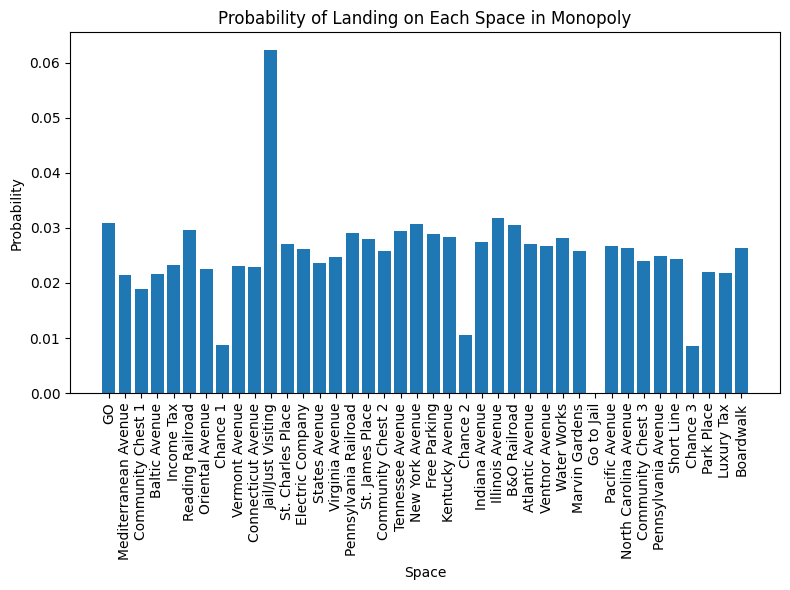

In [7]:
plt.figure(figsize=(8, 6))
plt.bar(df['Space'], df['Probability'])
plt.xticks(rotation=90)  # Rotate the space names for better readability
plt.xlabel('Space')
plt.ylabel('Probability')
plt.title('Probability of Landing on Each Space in Monopoly')
plt.tight_layout()
plt.show()

Note the extremely low probabilities of the Chance tiles and Go to Jail. This isn't because they weren't landed on, but because rather than counting each square you land on I counted each square you END YOUR TURN on. Go to Jail becomes 0 because you can't end a turn at that square, you are teleported to Jail. Similarly, 10/16 of the Chance cards teleport you to some other square, lowering the probabilities of ending a turn on one of the Chance cards significantly. Next I will create a graph showing the order of probabilities from highest to lowest:

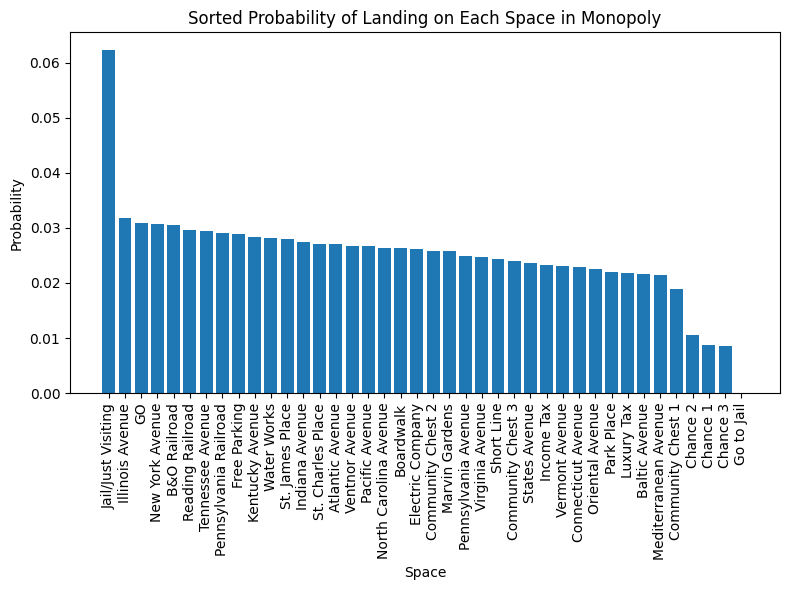

Highest probability spaces to land on:


,Space,Frequency,Probability
10,Jail/Just Visiting,744582,0.062376
24,Illinois Avenue,380152,0.031847
0,GO,368630,0.030881
19,New York Avenue,366929,0.030739
25,B&O Railroad,364846,0.030564
5,Reading Railroad,353153,0.029585


In [12]:
#create a sorted df
df_sorted = df.sort_values(by='Probability', ascending=False)

#plot
plt.figure(figsize=(8, 6))
plt.bar(df_sorted['Space'], df_sorted['Probability'])
plt.xticks(rotation=90)  # Rotate the space names for better readability
plt.xlabel('Space')
plt.ylabel('Probability')
plt.title('Sorted Probability of Landing on Each Space in Monopoly')
plt.tight_layout()
plt.show()

print("Highest probability spaces to land on:")
df_sorted.head(6)

## Price Analysis!

In this section I will be working to establish expected profit values over 'time'(some amount of rolls) for each amount of houses on each property type. To start, I've recorded each property and their probabilities in a .csv file labeled "prices.csv" (also note this uses the $100 luxury tax which was established in 2008)

In [146]:
price_df = pd.read_csv("prices.csv")

price_df.head()

,location,location_type,base_cost,cost_per_house,no_set,set,1,2,3,4,5
0,GO,Misc,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mediterranean Avenue,Brown,-60.0,-50.0,2.0,4.0,10.0,30.0,90.0,160.0,250.0
2,Community Chest 1,Community Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Baltic Avenue,Brown,-60.0,-50.0,4.0,8.0,20.0,60.0,180.0,320.0,450.0
4,Income Tax,Fine,-200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Simple Introduction: Which base property is best

To begin to get my footing with this sort of calculation, I will be finding which single property is best assuming no property group bonuses or upgrades, adjusted for the probabilties we found above. Note that for the utilities I have found the Expected Value over all types of rolls, which is $28 when owning 1 or $70 when owning both (this loses some detail as the probabilities of landing on the utilities could be different than just a regular dice roll probability because of teleportations etc., changing this expected value, I may address this in the future)

In [147]:
base_price_df = price_df[['location', 'base_cost', 'no_set']].copy() #capture just the part of price we want
base_price_df['probability'] = df['Probability'].copy()

new_columns = {}

for i in range(1, 1200):
    new_columns[f"{i}"] = (base_price_df['no_set'] * base_price_df['probability'] * i) + base_price_df['base_cost']
new_columns_df = pd.DataFrame(new_columns)

base_price_df = pd.concat([base_price_df, new_columns_df], axis=1)


base_price_df = base_price_df.transpose()
col_names = base_price_df.iloc[0]

base_price_df = base_price_df.drop(base_price_df.index[:4]).reset_index(drop=True)
base_price_df.columns = col_names

base_price_df.head()

location,GO,Mediterranean Avenue,Community Chest 1,Baltic Avenue,Income Tax,Reading Railroad,Oriental Avenue,Chance 1,Vermont Avenue,Connecticut Avenue,...,Go to Jail,Pacific Avenue,North Carolina Avenue,Community Chest 3,Pennsylvania Avenue,Short Line,Chance 3,Park Place,Luxury Tax,Boardwalk
0,NaN,-59.957293,NaN,-59.913253,NaN,-199.260382,-99.864642,NaN,-99.861113,-119.816369,...,NaN,-299.306647,-299.314972,NaN,-319.301426,-199.392371,NaN,-349.233114,NaN,-398.684016
1,NaN,-59.914587,NaN,-59.826506,NaN,-198.520764,-99.729284,NaN,-99.722226,-119.632737,...,NaN,-298.613294,-298.629944,NaN,-318.602853,-198.784741,NaN,-348.466228,NaN,-397.368033
2,NaN,-59.87188,NaN,-59.739759,NaN,-197.781145,-99.593926,NaN,-99.583339,-119.449106,...,NaN,-297.919942,-297.944916,NaN,-317.904279,-198.177112,NaN,-347.699342,NaN,-396.052049
3,NaN,-59.829173,NaN,-59.653012,NaN,-197.041527,-99.458568,NaN,-99.444452,-119.265475,...,NaN,-297.226589,-297.259888,NaN,-317.205705,-197.569482,NaN,-346.932456,NaN,-394.736066
4,NaN,-59.786467,NaN,-59.566265,NaN,-196.301909,-99.32321,NaN,-99.305564,-119.081843,...,NaN,-296.533236,-296.57486,NaN,-316.507132,-196.961853,NaN,-346.16557,NaN,-393.420082


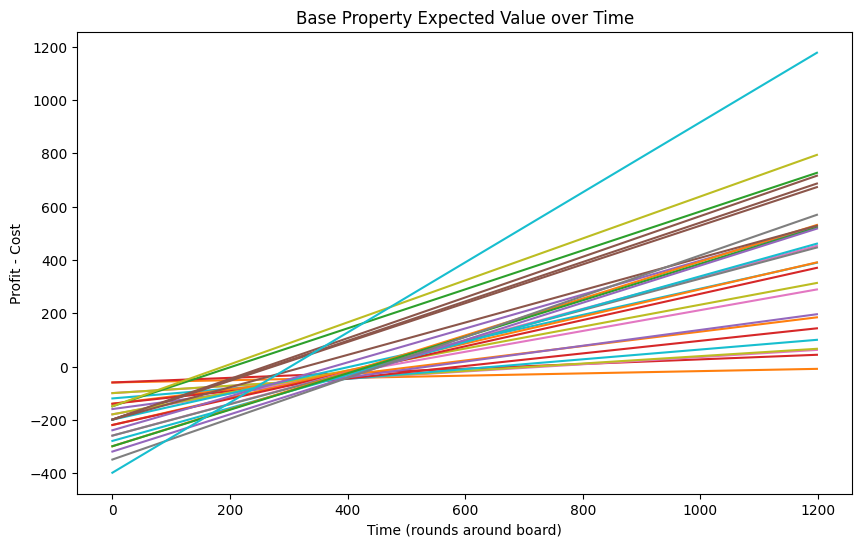

In [148]:
plt.figure(figsize=(10, 6))

# Plot each row (which corresponds to the original columns)
for column in base_price_df.columns:
    plt.plot(base_price_df.index, base_price_df[column], label=column)

# Adding labels and legend
plt.xlabel('Time (rounds around board)')
plt.ylabel('Profit - Cost')
plt.title('Base Property Expected Value over Time')
# plt.legend(title="Columns")
plt.show()

In [149]:
#print order of success at N = 1000
check_df = base_price_df.transpose()

check_df[1000] = check_df[1000].astype(float)
check_df_sorted = check_df.sort_values(by=1000, ascending=False)

counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 20:
        print(f"{counter}. {val}")

1. Boardwalk
2. Water Works
3. Electric Company
4. B&O Railroad
5. Reading Railroad
6. Pennsylvania Railroad
7. Park Place
8. Short Line
9. Illinois Avenue
10. Pacific Avenue
11. North Carolina Avenue
12. Pennsylvania Avenue
13. Marvin Gardens
14. Atlantic Avenue
15. Ventnor Avenue
16. New York Avenue
17. Kentucky Avenue
18. Indiana Avenue
19. Tennessee Avenue
20. St. James Place


We've done it! At the extremes these are the 20 best VALUE properties to own in Monopoly assuming no one gets more than one of a set of properties. However, if we're being realistic no one is ever going to play a game out to 1,000 times around the board so this value doesn't have too much meaning. Two values that have slightly more are going to be Return on Investment (amt of time until repay investment) and the value at the average time of a Monopoly game.

### Average Time of a Monopoly Game

This is pretty easy as we already have the values, we just need to decide what "Time" value we assign to the average game.

To do this I'll be manipulating some data from [this website](https://blog.ed.ted.com/2017/12/01/heres-how-to-win-at-monopoly-according-to-math-experts/) to make an estimation.

In [150]:
average_roll = 7
turns_per_player = 30 #estimate

total_tiles = average_roll * turns_per_player
total_rounds = total_tiles / 40 #number of times around (our Time variable)
print(f"On average in a game with {turns_per_player} turns per player you go {total_rounds} times around the board (not counting any teleportation)!")

On average in a game with 30 turns per player you go 5.25 times around the board (not counting any teleportation)!


In [171]:
check_df = base_price_df.transpose()

check_df[5] = check_df[5].astype(float) #this is actually the 6 time around the board rounding up because I can (should help offset some of the teleportation stuff)


check_df_sorted = check_df.sort_values(by=5, ascending=False)
counter = 0
for val in check_df_sorted.index.values:
    counter += 1
    if counter <= 10:
        print(f"{counter}. {val}")

1. Baltic Avenue
2. Mediterranean Avenue
3. Vermont Avenue
4. Oriental Avenue
5. Connecticut Avenue
6. St. Charles Place
7. States Avenue
8. Water Works
9. Electric Company
10. Virginia Avenue


As you can see with this metric the cheapest properties are given a great emphasis not because they are making good returns, but because they are the LEAST negative in their returns since the properties are really cheap. We'll do a quick check to see if any properties are able to buck this trend or if it is in strict price order.

In [154]:
price_order_df = check_df[[5]].copy()
individual_price_df = price_df['base_cost'].copy()

#getting them to match up
price_order_df_reset = price_order_df.reset_index()
price_order_df_reset.columns = ['location', '5']
individual_price_df_reset = individual_price_df.reset_index(drop=True)

price_order_df = pd.concat([price_order_df_reset, individual_price_df_reset], axis=1) #combining

price_order_df_sorted = price_order_df.sort_values(by='5', ascending=False)

price_order_df_sorted.head(28) #only gets tiles which are viable


,location,5,base_cost
3,Baltic Avenue,-59.479518,-60.0
1,Mediterranean Avenue,-59.743760,-60.0
8,Vermont Avenue,-99.166677,-100.0
6,Oriental Avenue,-99.187851,-100.0
9,Connecticut Avenue,-118.898212,-120.0
11,St. Charles Place,-138.375537,-140.0
13,States Avenue,-138.582101,-140.0
28,Water Works,-145.274004,-150.0
12,Electric Company,-145.611200,-150.0
14,Virginia Avenue,-158.217130,-160.0


As you can see the properties are in fact exactly in order of their price to buy! Not very conclusive about what properties are better than others : (

### Return On Investment

Here we can adjust the above work to not measure just the cost at "Time" count 5, but the % of the base cost recouped at that time, yielding more interesting results.

In [170]:
price_order_df_copy = price_order_df.copy()

price_order_df_copy['percent_change'] = (price_order_df_copy['5'] - price_order_df_copy['base_cost']) / (-1 * price_order_df_copy['base_cost'])
price_order_df_copy_sorted = price_order_df_copy.sort_values(by='percent_change', ascending=False).reset_index(drop=True)

price_order_df_copy_sorted.head(28) 

,location,5,base_cost,percent_change
0,Water Works,-145.274004,-150.0,0.031507
1,Electric Company,-145.611200,-150.0,0.029259
2,B&O Railroad,-195.415357,-200.0,0.022923
3,Reading Railroad,-195.562291,-200.0,0.022189
4,Pennsylvania Railroad,-195.629431,-200.0,0.021853
5,Boardwalk,-392.104098,-400.0,0.019740
6,Short Line,-196.354223,-200.0,0.018229
7,Illinois Avenue,-236.178418,-240.0,0.015923
8,New York Avenue,-197.049076,-200.0,0.014755
9,Kentucky Avenue,-216.943240,-220.0,0.013894


Notable here is the massive jumps of the utilities and the railroads. While I don't find the utilities data completely binding as it is still working on always hitting the average roll of 7 which I haven't fully checked the validity of yet, it's notable that the railroads (besides Short Line) even beat out Boardwalk (both the railroads and Boardwalk have some of the highest base %return at 1/8).

This leads us to the first actionable advice from this work: If there's any property you only want to have 1 of, it should either be Boardwalk or a railroad or a utility!